In this assignment we implement an ensemble method: Stacking.
We are going to train a neural network and a decision tree first, and then use their predictions as input to a second classifier: Logistic Regression.

We start as usual with installing some software.


In [ ]:
# SETUP
# install python at version 3.10
!apt-get install python3.10

# update symbolic links to the newly installed python version
!ln -sf /usr/bin/python3.10 /usr/bin/python
!ln -sf /usr/bin/python3.10 /usr/bin/python3

# install scikit-learn 1.2.2
%pip install scikit-learn==1.2.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10 is already the newest version (3.10.12-1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


Next we create a corpus and extract a train, a validation and a test set.

In [ ]:
import numpy as np
import random
import tensorflow as tf
from sklearn.datasets import make_blobs
from tensorflow.python.framework.random_seed import set_random_seed
from keras import initializers
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input
from keras.utils import to_categorical
from tensorflow.python.framework.random_seed import set_random_seed

X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
trainX, valtestX, trainy, valtesty = train_test_split(X, y, train_size=0.1, shuffle=False)
valX, testX, valy, testy = train_test_split(valtestX, valtesty, train_size=0.112, shuffle=False)
trainy_cat, valy_cat, testy_cat = to_categorical(trainy), to_categorical(valy), to_categorical(testy)

print(trainX.shape, valX.shape, testX.shape)

random.seed(42)
np.random.seed(42)
set_random_seed(42)


(110, 2) (110, 2) (880, 2)


**Exercise 2.1**

Let's train a Neural Network on the training set trainX.
The network uses:

*   an input layer, an hidden layer of dimension 25 with RELU activation function, an output layer of dimension 3 with softmax activation
*   categorical cross entropy as loss
*   adam as optimizer
*   valX as validation set. The option to the command fit for doing this is "validation_data=(valX, valy_cat)"
*   train for 500 epochs



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                75        
                                                                 
 dense_1 (Dense)             (None, 3)                 78        
                                                                 
Total params: 153 (612.00 Byte)
Trainable params: 153 (612.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


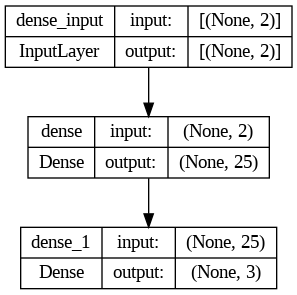

In [ ]:
# Add your code here
from keras.utils import plot_model

num_features = trainX.shape[1]
num_classes = 3

nn_model = Sequential()
nn_model.add(Dense(input_dim=num_features, units=25, activation='relu')) #input layer
nn_model.add(Dense(units=num_classes, activation='softmax')) #output layer

nn_model.summary()
plot_model(nn_model, show_shapes=True)  #plot of the model

In [ ]:
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #compile the model

history = nn_model.fit(trainX, trainy_cat, epochs=500, verbose=0, validation_data = (valX, valy_cat)) #train the model

we now check the performance of the network

Train: 0.873, Val: 0.818, Test: 0.810


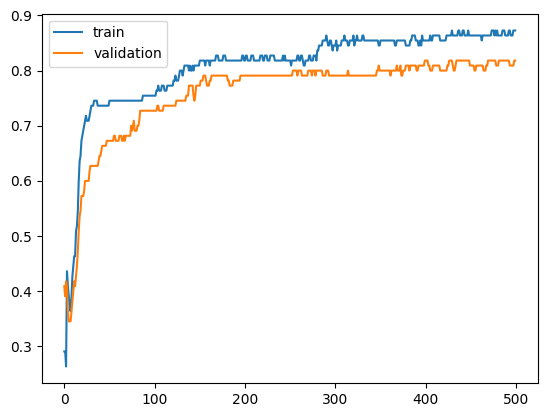

In [ ]:
_, train_acc = nn_model.evaluate(trainX, trainy_cat, verbose=0)
_, val_acc = nn_model.evaluate(valX, valy_cat, verbose=0)
_, test_acc = nn_model.evaluate(testX, testy_cat, verbose=0)
print('Train: %.3f, Val: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

**Exercise 2.2**

Initialise a decision tree (use *dt_model* as variable name) using random_state=123, setting maximum depth to 2 and using the default splitting criterion.

Train *dt_model* on trainX.

In [ ]:
# Add your code here
dt_model = DecisionTreeClassifier(random_state=123, max_depth=2)
dt_model.fit(trainX, trainy) #train the model

DecisionTreeClassifier(max_depth=2, random_state=123)

We check the accuracy on train, validation and test; we extract the probabilities for each class.

In [ ]:
print('Train: %.3f, Val: %.3f, Test: %.3f' % (dt_model.score(trainX, trainy), dt_model.score(valX, valy), dt_model.score(testX, testy)))
nn_scores_train, nn_scores_val, nn_scores_test = (nn_model.predict(trainX), nn_model.predict(valX), nn_model.predict(testX))
dt_scores_train, dt_scores_val, dt_scores_test = (dt_model.predict_proba(trainX), dt_model.predict_proba(valX), dt_model.predict_proba(testX))


Train: 0.836, Val: 0.709, Test: 0.773
28/28 [==============================] - 0s 1ms/step


 **Exercise 2.3**

 Let's consider a $\phi()$ function that maps an example of the dataset into 6 features:

1.   the probability of the example to belong to each class by the Neural Network model (first 3 features)
2.   the probability of the example to belong to each class by the Decision Tree (latest 3 features)

Let's create the corresponding training, validation and test datasets.
For the variable names, add the prefix "stacked_", for example stacked_X_train.

In [ ]:
# Add your code here
stacked_X_train = np.hstack((nn_scores_train, dt_scores_train))
stacked_X_val = np.hstack((nn_scores_val, dt_scores_val))
stacked_X_test = np.hstack((nn_scores_test, dt_scores_test))

In [ ]:
print(stacked_X_train.shape, stacked_X_val.shape, stacked_X_test.shape)

(110, 6) (110, 6) (880, 6)


**Exercise 2.4** We now train a Logistic Regression classifier on this new data we just created. Specifically, we set the maximum iterations to 500 and fit_intercept=True. We select the best value of the C parameter, among 0.001, 0.01, 0.1, 1, 10, 100, 1000, with respect to its accuracy on the validation set.
Finally, we print the accuracy of the best model (trained on the training set only) on the validation and test sets.


In [ ]:
# Add your code here
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
accuracy_list = []

for c in C:
  lr = LogisticRegression(C = c, max_iter = 200, fit_intercept=True)
  lr.fit(stacked_X_train, trainy)
  valy_pred = lr.predict(stacked_X_val) #estimation
  acc = accuracy_score(valy, valy_pred) #accuracy
  accuracy_list.append((acc, c))

accuracy_list.sort(reverse=True)

#select the best value of the C parameter
best_c = accuracy_list[0][1]
best_acc = accuracy_list[0][0]
print("The best parameter is C = {} and his accuracy is {}".format(best_c, best_acc))

best_model = LogisticRegression(C = best_c, max_iter = 200, fit_intercept=True)
best_model.fit(stacked_X_train, trainy)

valy_pred = best_model.predict(stacked_X_val)
testy_pred = best_model.predict(stacked_X_test)

print("Accuracy score of the best model on the validation is", accuracy_score(valy, valy_pred))
print("Accuracy score of the best model on the test is", accuracy_score(testy, testy_pred))

The best parameter is C = 100 and his accuracy is 0.8090909090909091
Accuracy score of the best model on the validation is 0.8090909090909091
Accuracy score of the best model on the test is 0.8136363636363636
